# Machine Learning

In [2]:
# Basics
import pandas as pd 
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.preprocessing import (
    OrdinalEncoder,
    StandardScaler
)

# Splitting data into training and testing
from sklearn.model_selection import train_test_split

# Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Imports for KNN and SVC/SVM models with GridSearchCV
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    validation_curve,
    learning_curve,
)
from sklearn import neighbors

# Metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# for SMOTE procedure
from imblearn.over_sampling import SMOTE 
from collections import Counter

## First models 

We are starting by testing multiple Machine Learning models on a cleaned simplified dataset.

Categorical => OneHotEncoder or one dimension with different values (1, 2, 3, 4, etc.)
- SEASON (4 classes)
- BASIN (7 classes)
- NATURE (6 classes)

Numeric => everything between 0 and 1
- LAT
- LON
- WIND 
- DIST2LAND
- STORM_SPEED
- STORM_DIR

### Choosing the pertient models

The different models can be found here :
https://scikit-learn.org/stable/machine_learning_map.html

| model | person | scores | encoding
| --- | --- | --- | --- | 
| Knn | Vincent | -- | OneHotEncoder/LabelBinarizer | 
| Knn | -- | -- | -- | 
| SVM | Vincent | -- | OneHotEncoder/LabelBinarizer | 
| SVM | -- | -- | -- | 
| Randomforest | Audrey | -- | OneHotEncoder/LabelBinarizer | 
| Randomforest | Audrey | -- | Categorical encoding | 
| LinearSVC | Arnaud | -- | OneHotEncoder/LabelBinarizer | 
| LinearSVC | Arnaud | -- | Categorical encoding | 
| -- | -- | -- | -- | 
| -- | -- | -- | -- | 
| -- | -- | -- | -- | 
| -- | -- | -- | -- | 
| -- | -- | -- | -- | 



The dataset can be imported with :

In [ ]:
df = pd.read_parquet("data/base.parquet", engine="pyarrow")


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45025 entries, 0 to 67409
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   SEASON        45025 non-null  object 
 1   BASIN         45025 non-null  object 
 2   NATURE        45025 non-null  object 
 3   LAT           45025 non-null  float64
 4   LON           45025 non-null  float64
 5   WIND          45025 non-null  float64
 6   DIST2LAND     45025 non-null  int64  
 7   STORM_SPEED   45025 non-null  float64
 8   STORM_DIR     45025 non-null  float64
 9   TD9636_STAGE  45025 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 3.8+ MB


In [ ]:

DATA = df.copy()

<Axes: xlabel='STORM_DIR', ylabel='STORM_SPEED'>

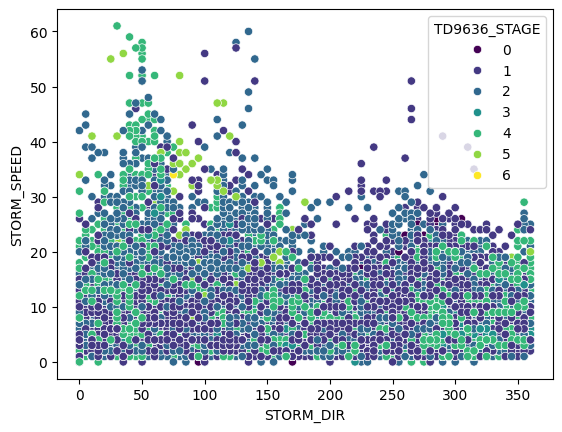

In [7]:
# plot
sns.scatterplot(
    x = 'STORM_DIR',
    y = 'STORM_SPEED',
    data = DATA,
    hue = 'TD9636_STAGE',
    palette = 'viridis',
)

# Nature
We remove the Nature column for a more real-life scenario.
This idea of the project is to predict storm classification thus it makes no sens if we already have a classification.
Less column, less computation time

In [8]:
# Remove NATURE column
DATA = DATA.drop(columns='NATURE')

# Encoding
BASIN column encoded with the creation of new binary columns to avoid giving weight to certain values.

For the SEASON column, we used the OrdinalEncoder() method to give more weight to seasons with more frequent and stronger storms.


In [9]:
# Encoding the BASIN column
# create new binary columns for each BASIN category
DATA = pd.concat([DATA,
                 pd.get_dummies(DATA.BASIN)],axis=1).drop(columns='BASIN')
DATA = DATA.drop(columns='WP')
# We remove WP column (following K-1 rules)

# Encoding the SEASON column
# Recode the season in integers. Give more importance to the seasons where the most storms occur
encoder = OrdinalEncoder(categories = [['Winter', 'Spring', 'Fall', 'Summer']]) 
DATA['SEASON'] = encoder.fit_transform(DATA[['SEASON']])


# Scaling the direction
STORM_DIR: as it is a direction it varies between 0° and 360° and 0° = 360°.
Thus it has to be handle in a specific way.

In [10]:
# scaling for direction: we need to extract the two components of the direction: 
DATA['STORM_DIR_X'] = np.cos(np.radians(DATA['STORM_DIR']))  # X component
DATA['STORM_DIR_Y'] = np.sin(np.radians(DATA['STORM_DIR']))  # Y component

# We can now drop the STORM_DIR column
DATA = DATA.drop(columns='STORM_DIR')

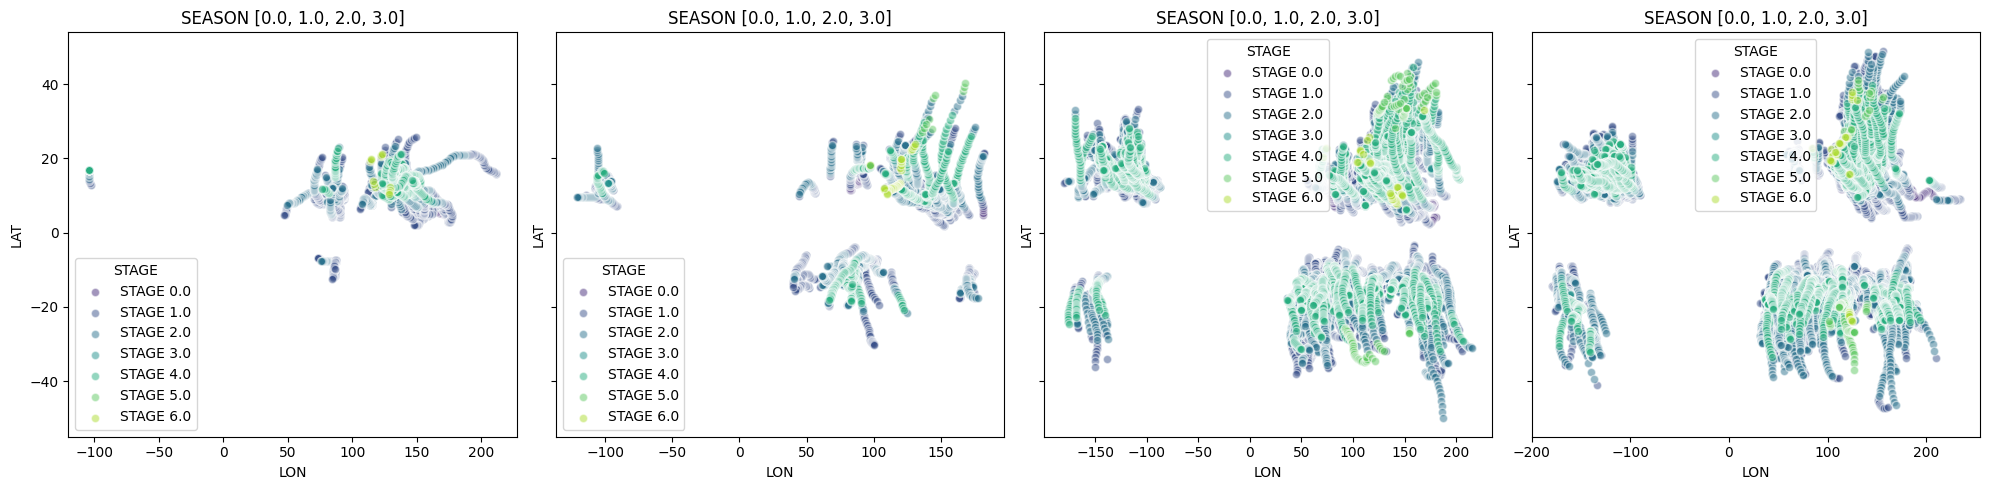

In [11]:
# Plot storm stages based on the season

season = sorted(DATA['SEASON'].unique())
num_season = len(season)

stages = sorted(DATA['TD9636_STAGE'].unique())
num_stages = len(stages)

# Create subplots
fig, axes = plt.subplots(1, num_season, figsize=(5 * num_season, 5), sharey=True)

# If only one stage, make sure axes is iterable
if num_season == 1:
    axes = [axes]

# Define color palette
palette = sns.color_palette('viridis', len(stages))  
stage_colors = dict(zip(stages, palette))  # Map STAGE to colors

# Plot each stage separately
for axe, ss in zip(axes, season):
    subset = DATA[DATA['SEASON'] == ss]

    for stage in stages:
        stage_data = subset[subset['TD9636_STAGE'] == stage]
        axe.scatter(stage_data['LON'], stage_data['LAT'], 
                    color=stage_colors[stage], 
                    label=f'STAGE {stage}', 
                    alpha=0.5, edgecolors='w')

        axe.set_title(f'SEASON {season}')
        axe.set_xlabel('LON')
        axe.set_ylabel('LAT')
        axe.legend(title='STAGE')



plt.tight_layout()
plt.show()

# storms also seem to be stronger in the northwest pacific

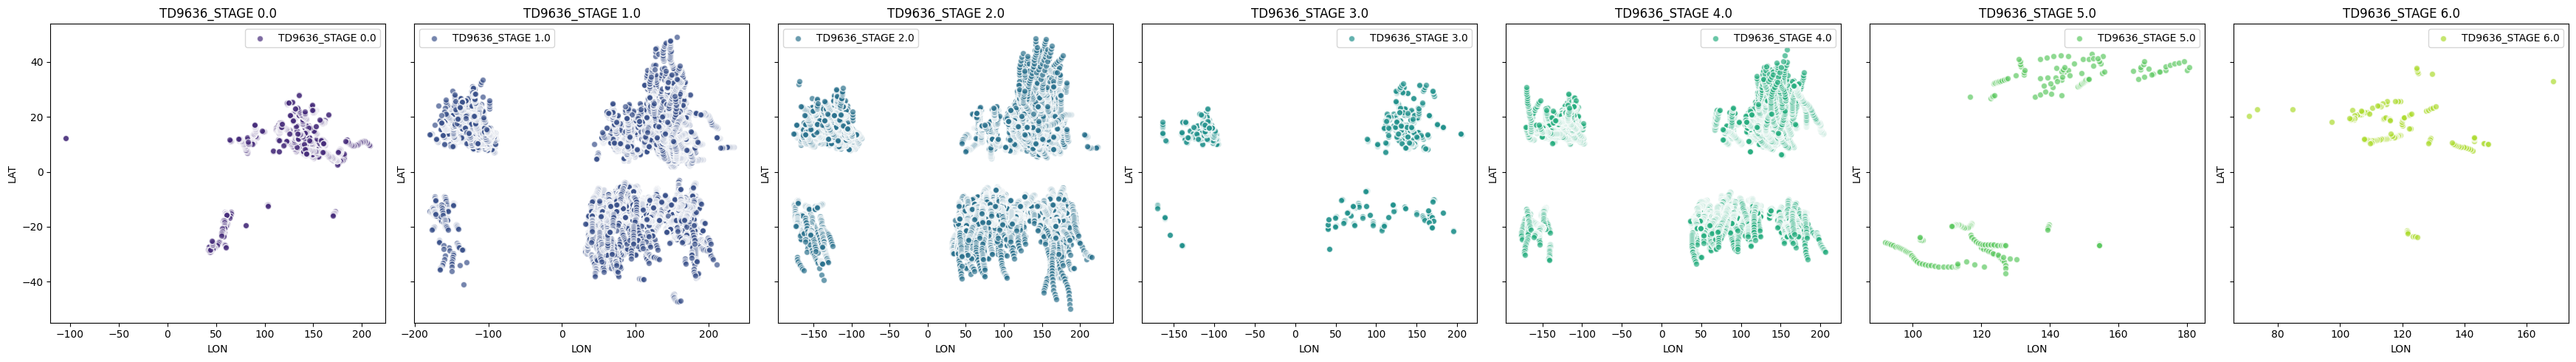

In [12]:
# Plot each stage separately as the number of points is too high and we don't see anything on the previous plot

stages = sorted(df['TD9636_STAGE'].unique())
num_stages = len(stages)

# Create subplots
fig, axes = plt.subplots(1, num_stages, figsize=(5 * num_stages, 5), sharey=True)

# If only one stage, make sure axes is iterable
if num_stages == 1:
    axes = [axes]

# Define color palette
palette = sns.color_palette('viridis', num_stages)

# Plot each stage separately
for axe, stage, color in zip(axes, stages, palette):
    subset = df[df['TD9636_STAGE'] == stage]
    axe.scatter(subset['LON'], subset['LAT'], color=color, label=f'TD9636_STAGE {stage}', alpha=0.7, edgecolors='w')
    axe.set_title(f'TD9636_STAGE {stage}')
    axe.set_xlabel('LON')
    axe.set_ylabel('LAT')
    axe.legend()

plt.tight_layout()
plt.show()

# The number of data is very unbalanced

# Correlation matrix
Stolen from Vincent

In [13]:
# Correlation matrix + heatmap using Plotly for the transformed data
# Checking the correlations to check our hypothesis before using the data with the ML Model
cm_df = DATA.corr()
cm_df = cm_df[((cm_df >= 0.2) | (cm_df <= -0.2)) & (cm_df != 1.00)]
cm_df = cm_df.dropna(how="all", axis=0).dropna(how="all", axis=1)

fig = px.imshow(
    cm_df,
    text_auto=".2f",
    zmin=-1,
    zmax=1,
    color_continuous_scale=px.colors.sequential.RdBu_r,
    title="Correlation Matrix Heatmap",
)

# Layout and show
fig.update_layout(
    title="Correlation Matrix",
    autosize=False,
    width=700,
    height=700,
)
fig.show()

# Spliting the dataset into training and testing subset 
We used 80 % for training and 20 % for testing

In [14]:
# creation of the training and test datasets
DATA_train, DATA_test = train_test_split(DATA ,test_size = 0.2)

DATA_train.TD9636_STAGE.value_counts().sort_index()
DATA_test.TD9636_STAGE.value_counts().sort_index()

# get the values of the columns for the training data
X_train = DATA_train.drop(columns='TD9636_STAGE')
y_train = DATA_train['TD9636_STAGE']

# get the values of the columns for the test data
X_test = DATA_test.drop(columns='TD9636_STAGE')
y_test = DATA_test['TD9636_STAGE']

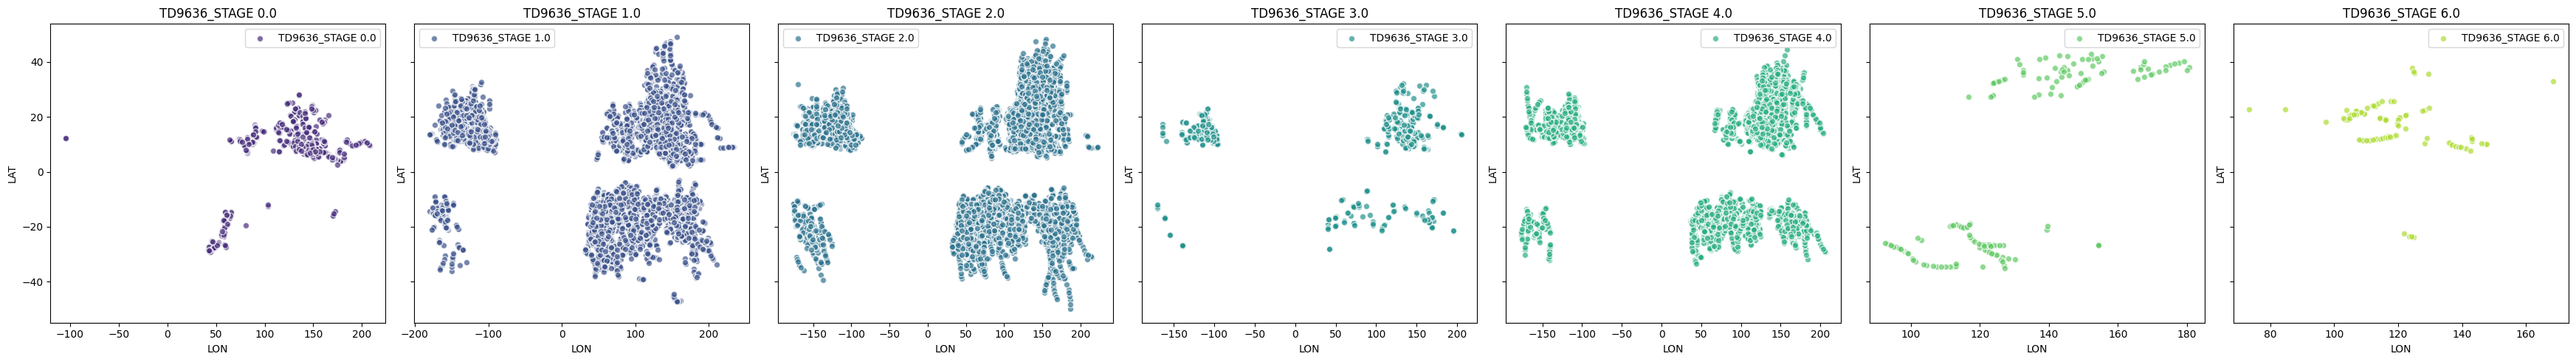

In [15]:
# Redo the plot with the training data just to have a look to what we have

stages = sorted(DATA_train['TD9636_STAGE'].unique())
num_stages = len(stages)

# Create subplots
fig, axes = plt.subplots(1, num_stages, figsize=(5 * num_stages, 5), sharey=True)

# If only one stage, make sure axes is iterable
if num_stages == 1:
    axes = [axes]

# Define color palette
palette = sns.color_palette('viridis', num_stages)

# Plot each stage separately
for axe, stage, color in zip(axes, stages, palette):
    subset = DATA_train[DATA_train['TD9636_STAGE'] == stage]
    axe.scatter(subset['LON'], subset['LAT'], color=color, label=f'TD9636_STAGE {stage}', alpha=0.7, edgecolors='w')
    axe.set_title(f'TD9636_STAGE {stage}')
    axe.set_xlabel('LON')
    axe.set_ylabel('LAT')
    axe.legend()

# adjust 
plt.tight_layout()
plt.show()

#### Scaling and Normalizing

We scale/normalize only numerical data : 
    - WIND, 
    - DIST2LAND, and 
    - STORM_SPEED

The data are scaled after spliting the data to avoid Data leakage.
StandardScaler() is the more appropriate method here (Gaussian data, not bounded data)

In [16]:
# Scaling 
col_to_scale = ['WIND', 'DIST2LAND', 'STORM_SPEED']

# Create the scaler
scaler = StandardScaler()

# Fit and transform the data:
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[col_to_scale] = scaler.fit_transform(X_train_scaled[col_to_scale])
X_test_scaled[col_to_scale] = scaler.transform(X_test_scaled[col_to_scale])


In [17]:
# Try an ensemble classifier: Random Forest

rf_model = RandomForestClassifier()
rf_model.fit(X=X_train_scaled,y=y_train)
y_test_predicted_rf = rf_model.predict(X_test_scaled)
report_rf = classification_report(y_pred=y_test_predicted_rf,y_true=y_test)

print(report_rf)


              precision    recall  f1-score   support

         0.0       0.96      0.61      0.75       160
         1.0       0.93      0.94      0.93      3100
         2.0       0.91      0.94      0.92      3431
         3.0       0.80      0.46      0.58       144
         4.0       0.94      0.94      0.94      2094
         5.0       0.92      0.49      0.64        49
         6.0       0.92      0.44      0.60        27

    accuracy                           0.92      9005
   macro avg       0.91      0.69      0.77      9005
weighted avg       0.92      0.92      0.92      9005



### KNeighbors
Method used in class

In [18]:
# KNeighbors Classifier 
knc_model = KNeighborsClassifier(n_neighbors=2)
knc_model.fit(X=X_train_scaled,y=y_train)
y_test_predicted_knc = knc_model.predict(X_test_scaled)
report_knc = classification_report(y_pred=y_test_predicted_knc,y_true=y_test)
print(report_knc)


              precision    recall  f1-score   support

         0.0       0.69      0.94      0.80       160
         1.0       0.86      0.96      0.91      3100
         2.0       0.90      0.86      0.88      3431
         3.0       0.54      0.60      0.57       144
         4.0       0.99      0.87      0.93      2094
         5.0       0.92      0.67      0.78        49
         6.0       1.00      0.37      0.54        27

    accuracy                           0.89      9005
   macro avg       0.84      0.75      0.77      9005
weighted avg       0.90      0.89      0.89      9005



#### KNN with GridSearchCV
From Vincent

In [19]:
# Hyperparameters
param_grid = {"n_neighbors": range(2, 51)}

# Score to optimize
score = "accuracy"

# KNN classifier with GridSearchCV
knn_classifier = GridSearchCV(
    neighbors.KNeighborsClassifier(),
    param_grid,
    scoring=score,
)

knn_classifier.fit(X=X_train_scaled,y=y_train)

# Results
print("Cross-validation results:\n")
for mean, std, params in zip(
    knn_classifier.cv_results_["mean_test_score"],
    knn_classifier.cv_results_["std_test_score"],
    knn_classifier.cv_results_["params"],
):
    print(
        "{} = {:.2f} (+/-{:.0f}) for {}".format(score, mean, std * 2, params)
    )

target_pred = knn_classifier.predict(X_train_scaled)
target_true = y_train

print("\n", classification_report(target_true, target_pred))

Cross-validation results:

accuracy = 0.87 (+/-0) for {'n_neighbors': 2}
accuracy = 0.87 (+/-0) for {'n_neighbors': 3}
accuracy = 0.84 (+/-0) for {'n_neighbors': 4}
accuracy = 0.83 (+/-0) for {'n_neighbors': 5}
accuracy = 0.81 (+/-0) for {'n_neighbors': 6}
accuracy = 0.81 (+/-0) for {'n_neighbors': 7}
accuracy = 0.80 (+/-0) for {'n_neighbors': 8}
accuracy = 0.79 (+/-0) for {'n_neighbors': 9}
accuracy = 0.78 (+/-0) for {'n_neighbors': 10}
accuracy = 0.78 (+/-0) for {'n_neighbors': 11}
accuracy = 0.77 (+/-0) for {'n_neighbors': 12}
accuracy = 0.76 (+/-0) for {'n_neighbors': 13}
accuracy = 0.76 (+/-0) for {'n_neighbors': 14}
accuracy = 0.76 (+/-0) for {'n_neighbors': 15}
accuracy = 0.75 (+/-0) for {'n_neighbors': 16}
accuracy = 0.75 (+/-0) for {'n_neighbors': 17}
accuracy = 0.74 (+/-0) for {'n_neighbors': 18}
accuracy = 0.74 (+/-0) for {'n_neighbors': 19}
accuracy = 0.74 (+/-0) for {'n_neighbors': 20}
accuracy = 0.73 (+/-0) for {'n_neighbors': 21}
accuracy = 0.73 (+/-0) for {'n_neighbors'

In [20]:
cm = confusion_matrix(target_true, target_pred)
cm_percent = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

# Custom labels
labels = [f"Stage {i}" for i in range(7)]

# Create a heatmap using Plotly
fig = px.imshow(
    cm_percent,
    text_auto=".2f",
    aspect="auto",
    title="Confusion Matrix - KNN GridSearch CV",
    labels=dict(color="Count"),
    x=labels,
    y=labels,
    color_continuous_scale=px.colors.sequential.tempo,
)

fig.show()

In [21]:
print(f"Best parameters : {knn_classifier.best_params_}\n")
print(f"Best accuracy score : {knn_classifier.best_score_}\n")
print(f"Best estimator : {knn_classifier.best_estimator_}")

Best parameters : {'n_neighbors': 2}

Best accuracy score : 0.8658800666296502

Best estimator : KNeighborsClassifier(n_neighbors=2)


In [22]:
# Calculate learning curve
train_sizes, train_scores, valid_scores = learning_curve(
    knn_classifier.best_estimator_,
    X_train_scaled,
    y_train,
    train_sizes=np.linspace(0.1, 1, 50),
    cv=5,
    scoring="accuracy",
)

# Calculate mean scores
train_scores_mean = np.mean(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)

# Create a plotly figure
fig = go.Figure()

# Add train scores
fig.add_trace(
    go.Scatter(x=train_sizes, y=train_scores_mean, mode="lines", name="Train")
)

# Add validation scores
fig.add_trace(
    go.Scatter(
        x=train_sizes, y=valid_scores_mean, mode="lines", name="Validation"
    )
)

# Update layout and display
fig.update_layout(
    title="KNN Learning Curve",
    xaxis_title="Training Size",
    yaxis_title="Accuracy",
    legend=dict(x=0, y=1, traceorder="normal"),
)
fig.show()

## SMOTE procedure to balance the sampling between stages
We used smote procedure only on training data.
Test data need to stay nice and clean as it is better to test our model with empirical data rather than simulated. 

We apply SMOTE after splitting but before scaling.

In [23]:
# SMOTE procedure

# Initialize SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Fit and resample training data
X_SMOTE, y_SMOTE = smote.fit_resample(X_train, y_train)

In [24]:
coutner_y_train = Counter(y_train)
counter_y_SMOTE = Counter(y_SMOTE)
print(coutner_y_train, 
      counter_y_SMOTE)

Counter({2.0: 13648, 1.0: 12309, 4.0: 8496, 0.0: 693, 3.0: 598, 5.0: 176, 6.0: 100}) Counter({1.0: 13648, 2.0: 13648, 4.0: 13648, 3.0: 13648, 0.0: 13648, 5.0: 13648, 6.0: 13648})


# Plot after SMOTE


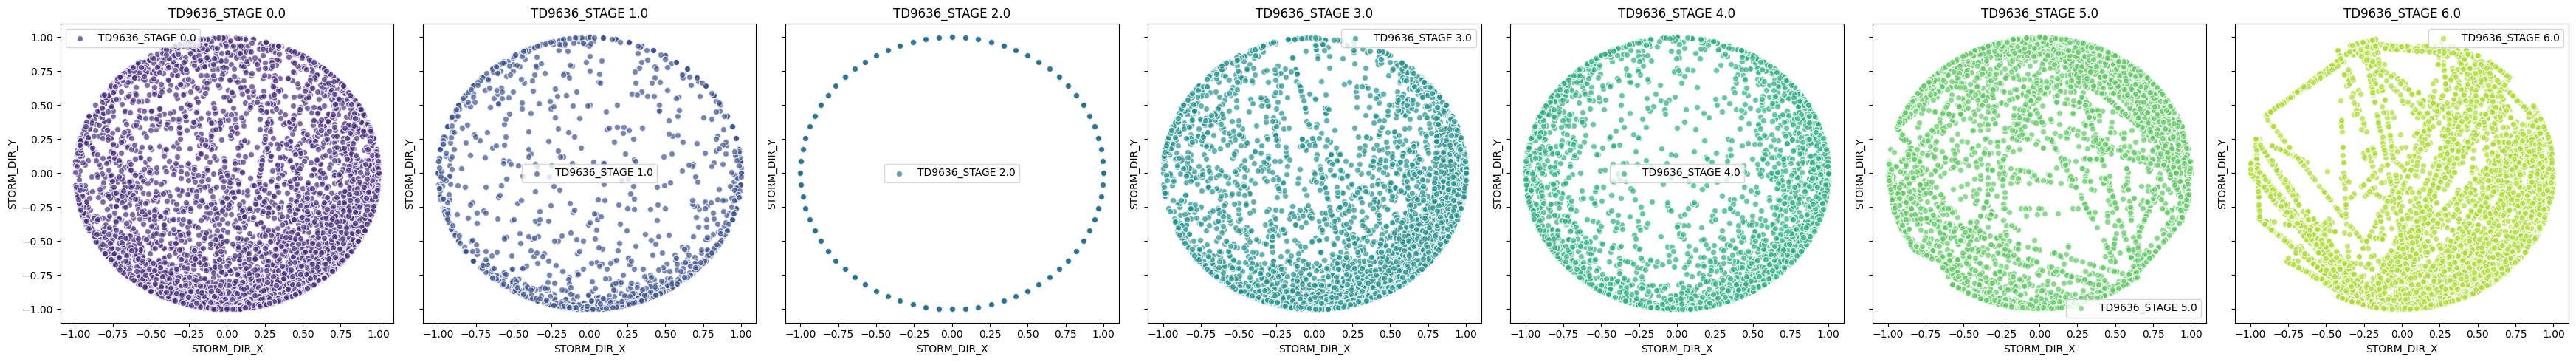

In [ ]:
# Merge X and y
X_SMOTE_plt = X_SMOTE.reset_index()
y_SMOTE_plt = y_SMOTE.reset_index()

data_plot = pd.merge(X_SMOTE_plt, y_SMOTE_plt, on="index")

# Redo the plot with the SMOTE data

stages = sorted(data_plot['TD9636_STAGE'].unique())
num_stages = len(stages)

# Create subplots
fig, axes = plt.subplots(1, num_stages, figsize=(5 * num_stages, 5), sharey=True)

# If only one stage, make sure axes is iterable
if num_stages == 1:
    axes = [axes]

# Define color palette
palette = sns.color_palette('viridis', num_stages)

# Plot each stage separately
for axe, stage, color in zip(axes, stages, palette):
    subset = data_plot[data_plot['TD9636_STAGE'] == stage]
    axe.scatter(subset['STORM_DIR_X'], subset['STORM_DIR_Y'], color=color, label=f'TD9636_STAGE {stage}', alpha=0.7, edgecolors='w')
    axe.set_title(f'TD9636_STAGE {stage}')
    axe.set_xlabel('STORM_DIR_X')
    axe.set_ylabel('STORM_DIR_Y')
    axe.legend()

# adjust 
plt.tight_layout()
plt.show()


# Problem OUTLIERS ???

# STAGE 2 ??????????


# Scaling of the smote training dataset

In [29]:
# Scaling 
col_to_scale = ['WIND', 'DIST2LAND', 'STORM_SPEED']

# Create the scaler
scaler = StandardScaler()

# Fit and transform the data:
X_SMOTE_scaled = X_SMOTE.copy()
X_SMOTE_scaled[col_to_scale] = scaler.fit_transform(X_SMOTE_scaled[col_to_scale])


#### KNN with GridSearchCV 
Using SMOTE data

In [30]:
# Hyperparameters
param_grid = {"n_neighbors": range(2, 30)}

# Score to optimize
score = "accuracy"

# KNN classifier with GridSearchCV
knn_classifier = GridSearchCV(
    neighbors.KNeighborsClassifier(),
    param_grid,
    scoring=score,
)

knn_classifier.fit(X=X_SMOTE_scaled,y=y_SMOTE)

# Results
print("Cross-validation results:\n")
for mean, std, params in zip(
    knn_classifier.cv_results_["mean_test_score"],
    knn_classifier.cv_results_["std_test_score"],
    knn_classifier.cv_results_["params"],
):
    print(
        "{} = {:.2f} (+/-{:.0f}) for {}".format(score, mean, std * 2, params)
    )

target_pred = knn_classifier.predict(X_SMOTE_scaled)
target_true = y_SMOTE

print("\n", classification_report(target_true, target_pred))

Cross-validation results:

accuracy = 0.93 (+/-0) for {'n_neighbors': 2}
accuracy = 0.92 (+/-0) for {'n_neighbors': 3}
accuracy = 0.91 (+/-0) for {'n_neighbors': 4}
accuracy = 0.90 (+/-0) for {'n_neighbors': 5}
accuracy = 0.89 (+/-0) for {'n_neighbors': 6}
accuracy = 0.89 (+/-0) for {'n_neighbors': 7}
accuracy = 0.88 (+/-0) for {'n_neighbors': 8}
accuracy = 0.87 (+/-0) for {'n_neighbors': 9}
accuracy = 0.87 (+/-0) for {'n_neighbors': 10}
accuracy = 0.86 (+/-0) for {'n_neighbors': 11}
accuracy = 0.85 (+/-0) for {'n_neighbors': 12}
accuracy = 0.85 (+/-0) for {'n_neighbors': 13}
accuracy = 0.85 (+/-0) for {'n_neighbors': 14}
accuracy = 0.84 (+/-0) for {'n_neighbors': 15}
accuracy = 0.84 (+/-0) for {'n_neighbors': 16}
accuracy = 0.83 (+/-0) for {'n_neighbors': 17}
accuracy = 0.83 (+/-0) for {'n_neighbors': 18}
accuracy = 0.83 (+/-0) for {'n_neighbors': 19}
accuracy = 0.82 (+/-0) for {'n_neighbors': 20}
accuracy = 0.82 (+/-0) for {'n_neighbors': 21}
accuracy = 0.82 (+/-0) for {'n_neighbors'

In [31]:
cm = confusion_matrix(target_true, target_pred)
cm_percent = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

# Custom labels
labels = [f"Stage {i}" for i in range(7)]

# Create a heatmap using Plotly
fig = px.imshow(
    cm_percent,
    text_auto=".2f",
    aspect="auto",
    title="Confusion Matrix - KNN GridSearch CV",
    labels=dict(color="Count"),
    x=labels,
    y=labels,
    color_continuous_scale=px.colors.sequential.tempo,
)

fig.show()

In [32]:
print(f"Best parameters : {knn_classifier.best_params_}\n")
print(f"Best accuracy score : {knn_classifier.best_score_}\n")
print(f"Best estimator : {knn_classifier.best_estimator_}")

Best parameters : {'n_neighbors': 2}

Best accuracy score : 0.9266454039078911

Best estimator : KNeighborsClassifier(n_neighbors=2)


In [33]:
# Calculate learning curve
train_sizes, train_scores, valid_scores = learning_curve(
    knn_classifier.best_estimator_,
    X_SMOTE_scaled,
    y_SMOTE,
    train_sizes=np.linspace(0.1, 1, 50),
    cv=5,
    scoring="accuracy",
)

# Calculate mean scores
train_scores_mean = np.mean(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)

# Create a plotly figure
fig = go.Figure()

# Add train scores
fig.add_trace(
    go.Scatter(x=train_sizes, y=train_scores_mean, mode="lines", name="Train")
)

# Add validation scores
fig.add_trace(
    go.Scatter(
        x=train_sizes, y=valid_scores_mean, mode="lines", name="Validation"
    )
)

# Update layout and display
fig.update_layout(
    title="KNN Learning Curve",
    xaxis_title="Training Size",
    yaxis_title="Accuracy",
    legend=dict(x=0, y=1, traceorder="normal"),
)
fig.show()

KeyboardInterrupt: 